<a href="https://www.kaggle.com/code/shaileshkumar591/llm-detect?scriptVersionId=158786395" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
#from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import lightgbm as lgbm


import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape,Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D,UpSampling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


df_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
df_prompt = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv")
test1 = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
df_essay.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [3]:
use = hub.load("/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2")

In [4]:
df_train_essays_ext = pd.read_csv('/kaggle/input/new-data/train_v2_drcat_02.csv')

df_train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [5]:
df_train_essays_ext.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

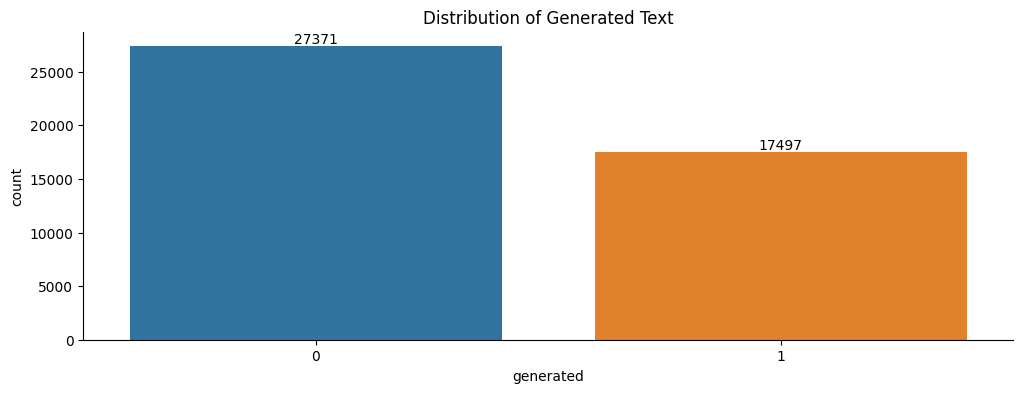

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext,
                   x="generated")

abs_values = df_train_essays_ext['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [7]:
df_train_essays_final = pd.concat([df_train_essays_ext[["text", "generated"]], df_essay[["text", "generated"]]])
import re # regular expression library
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
def normalize(text):
    # Replace with whitespace to separate '\n\nFor'
    text = text.replace(r"\n", r" ")
    text = text.replace(r"\r", r" ")
    # Drop puntuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces from '  For' to ' For'
    text = re.sub(r"\s+", r" ", text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #lower case the all capital alphabets
    text=text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

df_train_essays_final['text'] = df_train_essays_final['text'].apply(lambda x: normalize(x))
test1['text'] = test1['text'].apply(lambda x: normalize(x))

df_train_essays_final.info()

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
<class 'pandas.core.frame.DataFrame'>
Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
#from tensorflow.keras.preprocessing.text import Tokenizer
#tokenizer=Tokenizer()
#tokenizer.fit_on_texts(df_train_essays_final['text'])# gives a index on each word
#b1=len(tokenizer.word_index)# total no of words

In [9]:
#a=tokenizer.texts_to_sequences(df_train_essays_final['text'])
#maxi=max(len(x) for x in a)

In [10]:
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#a1=pad_sequences(a,maxlen=maxi,padding='post')

#df_train_essays_final['text']=a1.tolist()
#import numpy as np
#X = np.vstack(df_train_essays_final['text'].to_numpy())
#y=np.vstack(df_train_essays_final['generated'].to_numpy())

In [11]:
df_train_essays_final.head()

,text,generated
0,phones modern humans today always phone always...,0
1,essay explain drivers able use electronic devi...,0
2,driving use cellular devices today society tho...,0
3,phones driving drivers able use phones operati...,0
4,cell phone operation driving ability stay conn...,0


In [12]:
#X_train, X_val, y_train, y_val = train_test_split(df_train_essays_final['text'], df_train_essays_final['generated'], test_size=0.2, random_state = 300)

In [13]:
X_train = []
for r in tqdm(df_train_essays_final.text.values):
    if isinstance(r, str) and r:  # Check if r is a non-empty string
        emb = use([r])  # Pass r as a list to the USE
        review_emb = tf.reshape(emb, [-1]).numpy()
        X_train.append(review_emb)
    else:
        print(f"Skipping value: {r}")

X_train = np.array(X_train)
y_train = df_train_essays_final.generated.values

# Embed sentences for the validation set
Val_test = []
for r in tqdm(test1.text.values):
    if isinstance(r, str) and r:  # Check if r is a non-empty string
        emb = use([r])  # Pass r as a list to the USE
        review_emb = tf.reshape(emb, [-1]).numpy()
        Val_test.append(review_emb)
    else:
        print(f"Skipping value: {r}")

100%|██████████| 3/3 [00:00<00:00, 177.39it/s]


In [14]:
# LGBM

# Split data into train and testing data
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.1, random_state = 42)

# Get the train and test data for the training sequence
train_data = lgbm.Dataset(X_train, label=y_train)
test_data = lgbm.Dataset(X_test, label=y_test)

# Parameters we'll use for the prediction
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'dart',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

# Train the classifier
classifier = lgbm.train(parameters,
                       train_data,
                       valid_sets= test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

# PREDICTION
val_pred = classifier.predict(Val_test)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[1]	valid_0's auc: 0.870522
[2]	valid_0's auc: 0.916506
[3]	valid_0's auc: 0.934828
[4]	valid_0's auc: 0.948467


/opt/conda/lib/python3.10/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[5]	valid_0's auc: 0.95094
[6]	valid_0's auc: 0.953371
[7]	valid_0's auc: 0.954446
[8]	valid_0's auc: 0.954813
[9]	valid_0's auc: 0.955746
[10]	valid_0's auc: 0.95557
[11]	valid_0's auc: 0.956984
[12]	valid_0's auc: 0.958019
[13]	valid_0's auc: 0.958816
[14]	valid_0's auc: 0.960253
[15]	valid_0's auc: 0.961883
[16]	valid_0's auc: 0.962305
[17]	valid_0's auc: 0.963353
[18]	valid_0's auc: 0.964154
[19]	valid_0's auc: 0.965442
[20]	valid_0's auc: 0.966468
[21]	valid_0's auc: 0.966566
[22]	valid_0's auc: 0.967324
[23]	valid_0's auc: 0.967918
[24]	valid_0's auc: 0.969204
[25]	valid_0's auc: 0.969489
[26]	valid_0's auc: 0.970225
[27]	valid_0's auc: 0.970421
[28]	valid_0's auc: 0.97054
[29]	valid_0's auc: 0.971301
[30]	valid_0's auc: 0.972103
[31]	valid_0's auc: 0.972217
[32]	valid_0's auc: 0.972688
[33]	valid_0's auc: 0.972919
[34]	valid_0's auc: 0.973407
[35]	valid_0's auc: 0.973391
[36]	valid_0's auc: 0.973414
[37]	valid_0's auc: 0.973741
[38]	valid_0's auc: 0.973922
[39]	valid_0's auc: 0.

In [15]:
'''tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=512)'''

"tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True, padding=True, truncation=True, max_length=512)"

In [16]:
'''encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
encoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')'''

"encoded_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')\nencoded_val = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='pt')"

In [17]:
'''train_labels = torch.tensor(y_train.values)
val_labels = torch.tensor(y_val.values)'''

'train_labels = torch.tensor(y_train.values)\nval_labels = torch.tensor(y_val.values)'

In [18]:
'''train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)
val_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)'''

"train_dataset = TensorDataset(encoded_train['input_ids'], encoded_train['attention_mask'], train_labels)\nval_dataset = TensorDataset(encoded_val['input_ids'], encoded_val['attention_mask'], val_labels)"

In [19]:
'''train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)'''

'train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)'

In [20]:
'''model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)'''

'model = BertForSequenceClassification.from_pretrained(\'distilbert-base-uncased\', num_labels=2)\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)'

In [21]:
'''optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")'''

'optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)\nepochs = 20\n\nfor epoch in range(epochs):\n    model.train()\n    total_loss = 0\n\n    for batch in train_loader:\n        input_ids, attention_mask, labels = batch\n        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)\n\n        optimizer.zero_grad()\n\n        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)\n        loss = outputs.loss\n        total_loss += loss.item()\n\n        loss.backward()\n        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to avoid exploding gradients\n        optimizer.step()\n\n    avg_train_loss = total_loss / len(train_loader)\n    print(f"Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.2f}")'

In [22]:
'''class Positional_Embeddings(layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
        input_dim = sequence_length, output_dim = output_dim)
        self.token_embeddings = layers.Embedding(
        input_dim = vocab_size, output_dim = output_dim)    
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        positions = tf.range(start = 0, limit = length, delta = 1)
        embedded_positions = self.position_embeddings(positions)
        inputs = self.token_embeddings(inputs)
        return inputs + embedded_positions
    
    def compute_masks(self, inputs, masks = None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis = -1)
        return mask'''

'class Positional_Embeddings(layers.Layer):\n    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):\n        super().__init__(**kwargs)\n        self.position_embeddings = layers.Embedding(\n        input_dim = sequence_length, output_dim = output_dim)\n        self.token_embeddings = layers.Embedding(\n        input_dim = vocab_size, output_dim = output_dim)    \n        self.sequence_length = sequence_length\n        self.output_dim = output_dim\n        \n    def call(self, inputs):\n        length = tf.shape(inputs)[1]\n        positions = tf.range(start = 0, limit = length, delta = 1)\n        embedded_positions = self.position_embeddings(positions)\n        inputs = self.token_embeddings(inputs)\n        return inputs + embedded_positions\n    \n    def compute_masks(self, inputs, masks = None):\n        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis = -1)\n        return mask'

In [23]:
'''class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.3
        )
        self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation = tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        
        
    def call(self, inputs, mask = None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
            
        attention_output = self.attention(inputs, inputs, attention_mask = mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)'''

'class TransformerEncoder(layers.Layer):\n    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):\n        super().__init__(**kwargs)\n        self.embed_dim = embed_dim\n        self.dense_dim = dense_dim\n        self.num_heads = num_heads\n        self.attention = layers.MultiHeadAttention(\n        num_heads = num_heads, key_dim = embed_dim, dropout = 0.3\n        )\n        self.dense_proj = keras.Sequential(\n        [layers.Dense(dense_dim, activation = tf.nn.gelu), layers.Dense(embed_dim),]\n        )\n        self.layernorm1 = layers.LayerNormalization()\n        self.layernorm2 = layers.LayerNormalization()\n\n        \n        \n    def call(self, inputs, mask = None):\n        if mask is not None:\n            mask = mask[:, tf.newaxis, :]\n            \n        attention_output = self.attention(inputs, inputs, attention_mask = mask)\n        proj_input = self.layernorm1(inputs + attention_output)\n        proj_output = self.dense_proj(proj_input)\n        return

In [24]:
'''embed_dim = 10
heads = 10
dense_dim = 32
maxlen = maxi
vocab_size = b1+1

inputs = layers.Input(shape=(maxlen,))
embedding_layer = Positional_Embeddings(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, dense_dim, heads)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.30)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])'''

'embed_dim = 10\nheads = 10\ndense_dim = 32\nmaxlen = maxi\nvocab_size = b1+1\n\ninputs = layers.Input(shape=(maxlen,))\nembedding_layer = Positional_Embeddings(maxlen, vocab_size, embed_dim)\nx = embedding_layer(inputs)\ntransformer_block = TransformerEncoder(embed_dim, dense_dim, heads)\nx = transformer_block(x)\nx = layers.GlobalAveragePooling1D()(x)\nx = Dropout(0.30)(x)\noutputs = layers.Dense(1, activation="sigmoid")(x)\nmodel = Model(inputs=inputs, outputs=outputs)\n\n\nmodel.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=\'binary_crossentropy\', metrics=[\'accuracy\'])'

In [25]:
'''history = model.fit(X_train,y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=32,
                    )'''

'history = model.fit(X_train,y_train,\n                    validation_split=0.2,\n                    epochs=5,\n                    batch_size=32,\n                    )'

In [26]:
'''test_sequences = tokenizer.texts_to_sequences(test1['text'])
X_test_padded = pad_sequences(test_sequences, maxlen=maxi)  # Adjust maxlen based on your model

# Make predictions using the trained model
predictions = model.predict(X_test_padded)

# Assuming 'id' is the column containing unique identifiers in the test set
# Create a DataFrame to store the results
results_df = pd.DataFrame({'id': test1['id'], 'generated': predictions.flatten()})

# Save the results to a CSV file
results_df.to_csv('submission.csv', index=False)'''

"test_sequences = tokenizer.texts_to_sequences(test1['text'])\nX_test_padded = pad_sequences(test_sequences, maxlen=maxi)  # Adjust maxlen based on your model\n\n# Make predictions using the trained model\npredictions = model.predict(X_test_padded)\n\n# Assuming 'id' is the column containing unique identifiers in the test set\n# Create a DataFrame to store the results\nresults_df = pd.DataFrame({'id': test1['id'], 'generated': predictions.flatten()})\n\n# Save the results to a CSV file\nresults_df.to_csv('submission.csv', index=False)"

In [27]:
'''final=pd.read_csv('submission.csv')
final.head()'''

"final=pd.read_csv('submission.csv')\nfinal.head()"

In [28]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({'id': test1['id'], 'generated': val_pred.flatten()})

# Save the results to a CSV file
results_df.to_csv('submission.csv', index=False)